In [1]:
%autosave 10000

Autosaving every 10000 seconds


In [2]:
import numpy as np; import matplotlib.pyplot as plt
import pymc3 as pm; from scipy import stats; import pandas as pd ;import os 
import theano; import seaborn as sns; from theano import shared, tensor as tt
# Age, Age Error, 40Ar, 39Ar, 37Ar, 36Ar, Temperature


Couldn't import dot_parser, loading of dot files will not be possible.


In [3]:
cwd = os.chdir("/Users/jackcarter/Documents/Data_Mixtures")
df = pd.read_csv('aldercs_diff.csv')

In [4]:
from scipy import stats
from pymc3.distributions import draw_values
from pymc3.distributions import generate_samples
from pymc3.theanof import floatX
from pymc3.distributions.dist_math import bound
from pymc3.distributions import (Continuous, draw_values, generate_samples)

def assert_negative_support(var, label, distname, value=-1e-6):
    # Checks for evidence of positive support for a variable
    if var is None:
        return
    try:
        # Transformed distribution
        support = np.isfinite(var.transformed.distribution.dist
                              .logp(value).tag.test_value)
    except AttributeError:
        try:
            # Untransformed distribution
            support = np.isfinite(var.distribution.logp(value).tag.test_value)
        except AttributeError:
            # Otherwise no direct evidence of non-positive support
            support = False

    if np.any(support):
        msg = "The variable specified for {0} has negative support for {1}, ".format(
            label, distname)
        msg += "likely making it unsuitable for this parameter."
        warnings.warn(msg)

def get_tau_sigma(tau=None, sigma=None):
    if tau is None:
        if sigma is None:
            sigma = 1.
            tau = 1.
        else:
            tau = sigma**-2.
    else:
        if sigma is not None:
            raise ValueError("Can't pass both tau and sigma")
        else:
            sigma = tau**-.5
    tau = 1. * tau
    sigma = 1. * sigma
    return floatX(tau), floatX(sigma)

In [5]:
class weighted_Normal(pm.distributions.Continuous):

    def __init__(self, mu=0, sigma=None, tau=None, sd=None, weight =None,**kwargs):
        if sd is not None:
            sigma = sd
        tau, sigma = get_tau_sigma(tau=tau, sigma=sigma)
        self.sigma = self.sd = tt.as_tensor_variable(sigma)
        self.tau = tt.as_tensor_variable(tau)
        self.weight = tt.as_tensor_variable(weight)

        self.mean = self.median = self.mode = self.mu = mu = tt.as_tensor_variable(floatX(mu))
        self.variance = 1. / self.tau

        assert_negative_support(sigma, 'sigma', 'Normal')
        assert_negative_support(tau, 'tau', 'Normal')

        super().__init__(**kwargs)

    def random(self, point=None, size=None):
        
        mu, tau, _ = draw_values([self.mu, self.tau, self.sigma],
                                 point=point, size=size)
        return generate_samples(stats.norm.rvs, loc=mu, scale=tau**-0.5,
                                dist_shape=self.shape,
                                size=size)

    def logp(self, value):
        """
        Sum of Squares
        
        """
        sigma = self.sigma
        tau = self.tau
        mu = self.mu
        weight = self.weight
        
        logp =  - weight * tt.sqr(value - mu)/(2.0 * sigma * sigma)
        return logp.sum()


In [6]:
"""
Age

"""
age = df['Ageacs'].values
data = age
age_err = df['ageacerr'].values
age_m = age
N = age.shape[0]
age = data[data > 0]
ar39 = df['ar39'].values
age_data = df['Ageacs'].values

In [7]:
da2 = df['Da2'].values
da2_err = df['Da2_err'].values
temp = df['Temp'].values
time = np.ones(len(temp))*300
tempk = temp + 273.15

In [8]:
tplot = 1e4/(tempk)
def cumrel(x): 
    y = np.cumsum(x)
    z = y/y.max()
    return z
x_plot  = cumrel(ar39)

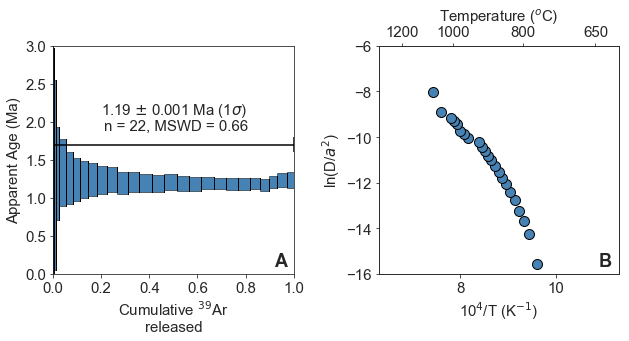

In [9]:
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 15}

plt.rc('font', **font)
sns.set_style('ticks')

fig,ax = plt.subplots(1,2, figsize = (9,5))


ax[0].fill_between(x_plot, 
                  age - age_err, 
                  age + age_err, 
                  facecolor = 'steelblue', 
                  step = 'pre',
                  lw = 0.5, 
                  edgecolor = 'k')

ax[0].set_ylabel('Apparent Age (Ma)')
ax[0].set_xlabel('Cumulative $^{39}$Ar\nreleased');
ax[0].set_xlim(0,1)

for i in range(len(x_plot)): 
    ax[0].vlines(x_plot, age - age_err, 
              age + age_err, 
              color = 'k', 
                lw = 0.5)


ax[1].plot(tplot, np.log(da2), 'o', 
          markerfacecolor = 'steelblue', 
          markeredgecolor = 'k', 
          markersize = 10)
ax[1].set_xlabel('10$^{4}$/T (K$^{-1}$)')
ax[1].set_ylabel('ln(D/$a^{2}$)')



ax2 = ax[1].twiny()

Tdc = np.array([650,  800, 1000, 1200])
Tp = 10e3/(Tdc + 273.15)
labels = list(['650', '800', '1000','1200'])
ax2.plot(tplot, np.log(da2), alpha = 0)
ax2.set_xlabel('Temperature ($^{o}$C)')
ax[1].set_xlim(Tp.min() - 0.5, Tp.max()+ .5)
ax2.set_xlim(Tp.min() - 0.5, Tp.max()+ .5)
ax2.set_xticks(Tp)
ax2.set_xticklabels(labels)

ax[1].set_ylim(-16, -6)
ax[0].set_ylim(0, 3)
plt.tight_layout()
text_str = '1.19 $\pm$ 0.001 Ma (1$\sigma$)'
text_str2 = 'n = 22, MSWD = 0.66'

ax[0].text(0.2, 2.1, text_str)
ax[0].text(0.21, 1.9, text_str2)

ax[0].hlines(1.7, 0, 1)
ax[0].vlines(0, 1.6, 1.8)
ax[0].vlines(1, 1.6, 1.8)

s1 = 'A'
s2= 'B'

ax[0].text(0.92, 0.1, s1, 
          fontweight = 'bold',
          fontsize = 18)

ax[1].text(10.9, -15.67, s2, 
          fontweight = 'bold',
          fontsize = 18)
plt.savefig('/Users/jackcarter/Desktop/chp3_figs/aldercreek_test.pdf')

In [10]:
"""
Data for Model
"""
N = len(age) - 1
from theano import shared, tensor as tt
age_data = shared(age[:N])
age_data_err = shared(age_err[:N])

arr_data = shared(np.log(da2[:N]))
arr_err_data = shared((da2_err[:N]/2)/da2[:N])
tempk = tempk[:N]
time = time[:N]

In [11]:
def inc_mdd(ea, d0, a,phi,temp, t):
    R = 8.314e-3
    D0t = ((phi/a)**2)* d0 * np.exp(-ea/(R*temp))*t
    q = (6./(np.pi**(3/2)))*np.sqrt((np.pi**2)*D0t)
    aa1 = np.sqrt(np.pi) * a**2 * R * temp**2
    bb1 = (phi/a)**2 * d0*np.exp(-ea/(R*temp))*t
    dd1 = 3 * d0 * ea * t * phi**2
    z1 = (dd1 * np.exp(-ea/(R*temp)))/(aa1 * np.sqrt(bb1))
    aa2 = a**2 * R *temp**2
    bb2 = (phi/a)**2 * d0*np.exp(-ea/(R*temp))*t
    cc1 = 3 * d0 * ea * t * phi**2 * np.exp(-ea/(R*temp))
    z2 = cc1/(np.sqrt(np.pi) * aa2 * np.sqrt(bb2)) - cc1/(aa2) 
    aa3 = a**2 * R * temp**2
    bb3 = (phi/a)**2 * d0*np.exp(-ea/(R*temp))*t
    cc2 = 6 * d0 * ea * t * phi**2
    z3 = (cc2 * np.exp(-(np.pi**2 * bb3) - (ea/(R*temp)))/(aa3))
    Q = tt.switch(q <= 0.9,
                z2,
                 z3)
    T = tt.switch(q < 0.1, 
                  z1,
                  Q)
    return T

In [12]:
"""
Stick Breaking 
"""
import pymc3.distributions.transforms as tr
from theano import tensor as tt
def stick_break(beta): 
    pr = tt.concatenate([[1], 
                         tt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * pr

In [13]:
"""
Test Models
"""
x_lin = 10000/tempk[0:N-1]
y_lin = np.log(da2[0:N-1])
y_lin_err = da2_err[0:N-1]/da2[0:N-1]
A = np.hstack(((np.ones(len(y_lin)).reshape(-1, 1), x_lin.reshape(-1,1))))
C = np.diag(y_lin_err)
C_inv = np.linalg.inv(C)
cov = np.linalg.inv(np.dot(A.T, np.dot(C_inv,A)))
X1 = np.dot(A.T, np.dot(C_inv, y_lin))
X = np.dot(cov, X1)
c, m = X
arr_test_model = m*x_lin + c

w_m_age = np.average(age, weights = age_err)
age_test_model = w_m_age*np.ones(len(data))

In [21]:
k = 20
m = 10
Q = pm.Model()
with Q: 
    """
    Global Number of Component 
    """
    alpha = pm.Gamma('alpha', 
                         1., 1.)

    beta = pm.Beta('beta', 1., alpha, 
                      shape = k)

    K_w = stick_break(beta)
    
    K = pm.Deterministic('K', 
                        K_w/K_w.sum(axis = 0,
                                    keepdims = True))
    
    C = pm.Categorical('C', 
                       p = K,
                       shape = (N,))
    
    """
    Number of Domains per component
    """
    
    phi = pm.Dirichlet('phi', 
                       np.linspace(1, 1e-10, m), 
                      shape = (k,m))
    
    D = pm.Categorical('D', 
                       p = phi[C], 
                       shape = N)

/Applications/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [22]:
with Q: 
    """
    Diffusion Kinetics
    - Activation energy 
    - Frequency Factor
    - With Hyperparameters
    """
    ea_mean = pm.Uniform('ea_mean',
                      lower = 80, 
                      upper = 500, 
                      shape = k, 
                        testval = 200)
    
    ea_sd = pm.HalfNormal('ea_sd',
                      sd = ea_mean/10, 
                      shape = k)
    
    ea = pm.Normal('ea',
                      mu = ea_mean, 
                      sd = ea_sd, 
                      shape = k)
    
    d0_mean = pm.Uniform('d0_mean',  
                      lower = 0.0, 
                      upper = 10000,
                      shape = k, 
                        testval = 200)
    
    d0_sd = pm.HalfNormal('d0_sd',  
                      sd = d0_mean/10, 
                      shape = k)
        
        
    d0 = pm.Normal('d0',  
                      mu = d0_mean, 
                      sd = d0_sd,
                      shape = k)

    pm.Potential('diff_kin_con', 
                tt.switch(ea < 80, 
                         -np.inf, 0)+ 
                tt.switch(ea > 500, 
                         -np.inf, 0) + 
                tt.switch(d0 < 0, 
                         -np.inf, 0) + 
                tt.switch(d0 > 10000, 
                         -np.inf, 0))



In [23]:
with Q: 
    """
    Grain size and/or domain size
    """
    a = pm.Uniform('a', lower = 0.00001, 
                  upper = 0.0063/2, 
                  shape = (k,m), 
                   testval = np.linspace(0.003, 0.0001, m))

In [24]:
with Q: 
    """
    Age Prior 
    with mean and standard deviation 
    hyperparameters
    
    """
    age_mean = pm.Uniform('age_mean',
                          lower = 0.0,
                          upper = 4600,
                              shape = k, 
                         testval= data.mean())
    
    age_sd = pm.HalfNormal('age_sd', 
                          sd = age_mean/10,
                          shape = k)
    
    age_model = pm.Normal('age_model', mu = age_mean, 
                         sd = age_sd, 
                         shape = k)
    
    pm.Potential('age_con', 
                tt.switch(age_model < 0, 
                         -np.inf, 0)+ 
                tt.switch(age_model > 4600, 
                         -np.inf, 0))

In [25]:
with Q: 
    """
    Indexing all the parameters
    """
    age_comp = pm.Deterministic('age_comp',
                                age_model[C])
    ea_comp = pm.Deterministic('ea_comp',
                               ea[C])
    d0_comp = pm.Deterministic('d0_comp',
                               d0[C])
    phi_comp = pm.Deterministic('phi_comp',
                                K[C])
    a_domain = pm.Deterministic("a_domain",
                                a[C,D])
    phi_domain = pm.Deterministic('phi_domain',
                                  phi[C,D])

/Applications/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [26]:
with Q: 
    """
    Age Model
    """
    Z2 = K[C] * inc_mdd(ea[C], 
                d0[C], 
                a[C,D], 
                phi[C,D],
                tempk[:,None],
                time[:,None])
    
    Y_sum2 = Z2.sum(axis = 1)
    
    XX = (Z2 * age_model[C]).sum(axis = 1)

    mu2 = (XX/Y_sum2)

/Applications/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [27]:
with Q: 
    """
    Incremental Release Trace
    """
    inc_rel = pm.Deterministic('inc_rel', Y_sum2)

In [28]:
with Q:
    """
    Arrhenius Model 
    """
    R = 8.314e-3
    y2 = K[C] * (((phi[C,D]/a[C,D])**2) \
                 * d0[C] * np.exp(-ea[C]/(R*tempk)))
    
    mu1 = tt.log(y2)

/Applications/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


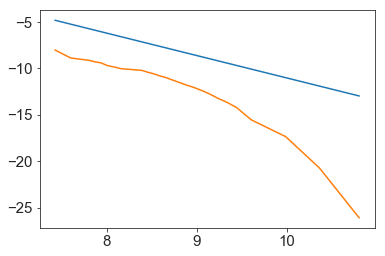

In [29]:
plt.plot(tplot[0:N], mu1.tag.test_value)
plt.plot(tplot[0:N], np.log(da2[0:N]))

In [33]:
"""
Calculate Model weights
"""
def logp_w(data, model, err): 
    y =   - ((data - model)**2)/(2*err * err)
    return y.sum()



with Q: 

    y1 = logp_w(data[:N], 
               age_test_model[:N],
                age_err[:N])
    y2 = logp_w(arr_data[:N-1], 
                arr_test_model[:N-1],
                arr_err_data[:N-1])

    
    weight = y1/y2


In [34]:
weight.tag.test_value

array(2.47499824e-07)

In [35]:
with Q: 
    """
    Arrhenius Likelihood
    """
    obs2 = weighted_Normal('obs2', mu1[:N],
                     arr_err_data[:N], 
                     observed = arr_data[:N], 
                           weight = weight)

In [36]:
with Q: 
    """
    Age Likelihood
    """
    obs1 = weighted_Normal('obs1', mu = mu2, 
                           sd = age_data_err[:N], 
                           observed = age_data[:N], 
                          weight = 1)

In [37]:
Q.check_test_point()

/Applications/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Applications/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Applications/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instea

alpha_log__                -1.00
beta_logodds__            -27.73
C                         -18.02
phi_stickbreaking__      -422.70
D                         -41.85
ea_mean_interval__        -31.78
ea_sd_log__               -15.40
ea                        -73.78
d0_mean_interval__        -78.64
d0_sd_log__               -15.40
d0                        -73.78
a_interval__             -401.06
age_mean_interval__      -165.50
age_sd_log__              -15.40
age_model                  29.00
obs2                  -208720.33
obs1                       -1.02
Name: Log-probability of test_point, dtype: float64

In [ ]:
SAMPLES = 50000
BURN = 600000
SEED = np.random.seed(123)

with Q:
    step1 = pm.CategoricalGibbsMetropolis([C,D]) 
    
    step2 = pm.Metropolis([d0, d0_sd, d0_mean,
                           ea, ea_mean, ea_sd,
                           age_mean,
                           age_sd, 
                          age_model, 
                           a, phi,
                          beta, 
                          alpha], 
                         scaling = 100)


    trace = pm.sample(SAMPLES, tune = BURN, 
                     step = [step1,
                             step2],
                     random_seed = SEED)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CategoricalGibbsMetropolis: [D, C]
>CompoundStep
>>Metropolis: [alpha]
>>Metropolis: [beta]
>>Metropolis: [phi]
>>Metropolis: [a]
>>Metropolis: [age_model]
>>Metropolis: [age_sd]
>>Metropolis: [age_mean]
>>Metropolis: [ea_sd]
>>Metropolis: [ea_mean]
>>Metropolis: [ea]
>>Metropolis: [d0_mean]
>>Metropolis: [d0_sd]
>>Metropolis: [d0]
/Applications/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Sampling 2 chains:  24%|██▎       | 308147/1300000 [4:21:41<18:51:03, 14.62draws/s]

In [ ]:
fig,ax = plt.subplots(1,2, figsize = (9, 4))
inc_model = trace['inc_rel'].mean(axis = 0)
frel_model = cumrel(inc_model)
ar39 = df['ar39'].values
ax[0].plot(temp[:N],
         ar39[:N]/ar39[:N].max(), 
          label = 'Data')
ax[0].plot(temp[:N], 
         trace['inc_rel'].mean(axis = 0)/trace['inc_rel'].mean(axis = 0).max(), 
          label = 'Model')

ax[0].set_ylabel('Normalised incremental\nrelease $^{39}$Ar')
ax[0].set_xlabel('Temperature ($^{o}$C)')


ax[1].plot(temp[:N], frel_model, lw = 1)

ax[1].plot(temp[:N], x_plot[:N])
ax[1].set_xlim(680, 1100)

ax[1].set_ylabel('Normalised cumulative\nrelease $^{39}$Ar')
ax[1].set_xlabel('Temperature ($^{o}$C)')

ax[0].legend()

s1 = 'A'
s2 = 'B'

ax[0].text(700, 0.965, s1, fontsize = 16, 
          fontweight = 'bold')

ax[1].text(700, 0.95, s2, fontsize = 16, 
          fontweight = 'bold')

plt.tight_layout()

In [ ]:
n_comp = np.apply_along_axis(lambda x: np.unique(x).size, 
                            1, trace['C'][-SAMPLES::10])

n_comp =  n_comp +1
ncmp = n_comp.mean(axis = 0).astype(int)
plt.figure(figsize = (ncmp*3, ncmp*0.75))
for i in range(ncmp):
    plt.subplot(1,ncmp,i+1)
    plt.plot(trace['age_model'][:,i],
        color = 'steelblue')

    plt.xlabel('iters')
    plt.ylabel('Age (Ma)')

plt.tight_layout()

In [ ]:
SAMPLES = 5000

/Applications/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


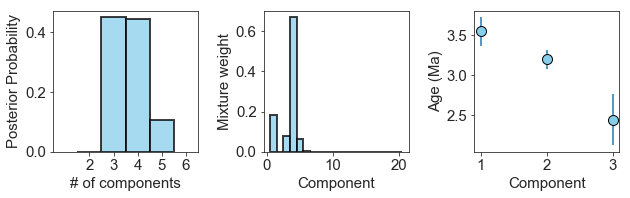

In [103]:
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 15}

plt.rc('font', **font)

fig, ax = plt.subplots(1, 3, figsize = (9, 3))
n_comp = np.apply_along_axis(lambda x: np.unique(x).size, 
                            1, trace['C'][-SAMPLES::10])

n_comp =  n_comp +1
ncmp = n_comp.mean(axis = 0).astype(int)
bins = np.arange(n_comp.min() -1, n_comp.max() +1)

ax[0].hist(n_comp,
        bins=bins,
        normed=True,
        lw= 2,
        alpha=0.75, 
       edgecolor = 'k', 
        facecolor = 'skyblue');

ax[0].set_xticks(bins + 0.5);
ax[0].set_xticklabels(bins);
ax[0].set_xlim(bins.min()-1,bins.max() + 1);
ax[0].set_xlabel('# of components');



plot_w = np.arange(k) + 1

ax[1].bar(plot_w - 0, trace['K'][-SAMPLES::10].mean(axis=0),
          width=1., lw=2, 
      edgecolor = 'k', alpha = 0.75, 
         facecolor = 'skyblue');

ax[1].set_xlabel('Component');

ax[1].set_ylabel('Mixture weight');

ax[1].locator_params(axis='x', nbins=12)

ax[2].errorbar(np.linspace(1, ncmp,ncmp),
             trace['age_model'][-SAMPLES::10].mean(axis = 0)[:ncmp].round(2), 
             yerr = 2*trace['age_model'][-SAMPLES::10].std(axis = 0)[:ncmp].round(2), 
             fmt ='o', 
             markersize = 10, 
             markeredgecolor = 'k', 
             markerfacecolor = 'skyblue')

ax[2].set_xlabel('Component');

ax[2].set_ylabel('Age (Ma)');
ax[0].set_ylabel('Posterior Probability')

ax[2].locator_params(axis='x', nbins=ncmp)
ax[1].locator_params(axis='x', nbins=ncmp)
#ax[1].set_xlim(0, ncmp+0.9)
#ax[2].set_xlim(0, ncmp+0.9)
#ax[2].set_ylim(1.15, 1.25)

plt.tight_layout()
plt.ticklabel_format(useOffset=False)
#plt.savefig('/Users/jackcarter/Desktop/hb_acs_test_model_nmp.pdf')

/Applications/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


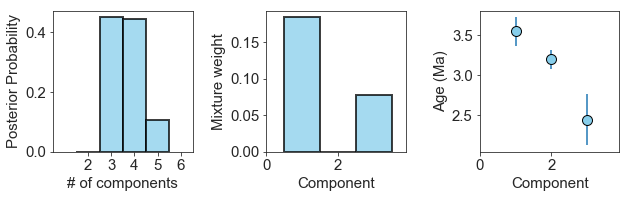

In [104]:
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 15}

plt.rc('font', **font)

fig, ax = plt.subplots(1, 3, figsize = (9, 3))
n_comp = np.apply_along_axis(lambda x: np.unique(x).size, 
                            1, trace['C'][-SAMPLES::10])

n_comp =  n_comp +1
ncmp = n_comp.mean(axis = 0).astype(int)
bins = np.arange(n_comp.min() -1, n_comp.max() +1)

ax[0].hist(n_comp,
        bins=bins,
        normed=True,
        lw= 2,
        alpha=0.75, 
       edgecolor = 'k', 
        facecolor = 'skyblue');

ax[0].set_xticks(bins + 0.5);
ax[0].set_xticklabels(bins);
ax[0].set_xlim(bins.min()-1,bins.max() + 1);
ax[0].set_xlabel('# of components');



plot_w = np.arange(ncmp) + 1

ax[1].bar(plot_w - 0, trace['K'][-SAMPLES::10].mean(axis=0)[:ncmp],
          width=1., lw=2, 
      edgecolor = 'k', alpha = 0.75, 
         facecolor = 'skyblue');

ax[1].set_xlabel('Component');

ax[1].set_ylabel('Mixture weight');

ax[1].locator_params(axis='x', nbins=12)

ax[2].errorbar(np.linspace(1, ncmp,ncmp),
             trace['age_model'][-SAMPLES::10].mean(axis = 0)[:ncmp].round(2), 
             yerr = 2*trace['age_model'][-SAMPLES::10].std(axis = 0)[:ncmp].round(2), 
             fmt ='o', 
             markersize = 10, 
             markeredgecolor = 'k', 
             markerfacecolor = 'skyblue')

ax[2].set_xlabel('Component');

ax[2].set_ylabel('Age (Ma)');
ax[0].set_ylabel('Posterior Probability')

ax[2].locator_params(axis='x', nbins=ncmp)
ax[1].locator_params(axis='x', nbins=ncmp)
ax[1].set_xlim(0, ncmp+0.9)
ax[2].set_xlim(0, ncmp+0.9)
#ax[2].set_ylim(1.15, 1.25)

plt.tight_layout()
plt.ticklabel_format(useOffset=False)
#plt.savefig('/Users/jackcarter/Desktop/hb_acs_test_model_nmp.pdf')

In [105]:
np.set_printoptions(suppress=True)
print(trace['age_model'][-SAMPLES::10].mean(axis = 0).round(4))


[3.5526 3.1988 2.4359 1.2053 0.138  0.7025 1.9537 0.117  2.196  1.5676
 0.692  0.8187 1.8274 0.9271 1.3083 0.3556 1.9727 3.1819 1.3394 0.6916]


In [106]:
trace['age_model'][-SAMPLES::10].std(axis = 0).round(4)

array([0.0927, 0.0619, 0.156 , 0.0269, 0.0172, 0.0352, 0.0684, 0.0121,
       0.0461, 0.0687, 0.0555, 0.0567, 0.1945, 0.0441, 0.1381, 0.0361,
       0.0831, 0.0472, 0.1693, 0.0445])

In [97]:
from scipy import stats
with Q: 
    ppc = pm.sample_ppc(trace,
                        1000)

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  after removing the cwd from sys.path.
  0%|          | 0/1000 [00:00<?, ?it/s]/Applications/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
100%|██████████| 1000/1000 [01:40<00:00,  9.92it/s]


In [73]:
# Mean Predictive Models
Z2 = ppc['obs1'].mean(axis = 0)
low2, high2 = np.percentile(ppc['obs1'], 
                            [2.5, 97.5], 
                            axis = 0)

# Frel_model
inc_model = trace['inc_rel'].mean(axis = 0)
frel_model = cumrel(inc_model)

In [74]:
sns.set_style('ticks')
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 16}

plt.rc('font', **font)

# Plotting parameters 
ar39 = cumrel(ar39)

low2_plot = np.insert(low2, 0, low2[0])
high2_plot = np.insert(high2, 0, high2[0])
z2_plot = np.insert(Z2, 0, Z2[0])
frel_model_plot = np.insert(frel_model, 0, 0)

data2_plot = np.insert(ar39, 0, 0)
data_plot = np.insert(data, 0, data[0])
age_err_plot = np.insert(age_err, 0, age_err[0])


In [75]:
tplot = 10000/tempk

# Mean Predictive Models
Z1 = ppc['obs2'].mean(axis = 0)
low1, high1 = np.percentile(ppc['obs2'], [50 - 34, 50 + 34], axis = 0)

In [76]:
age_data = df['Ageacs'].values

/Applications/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


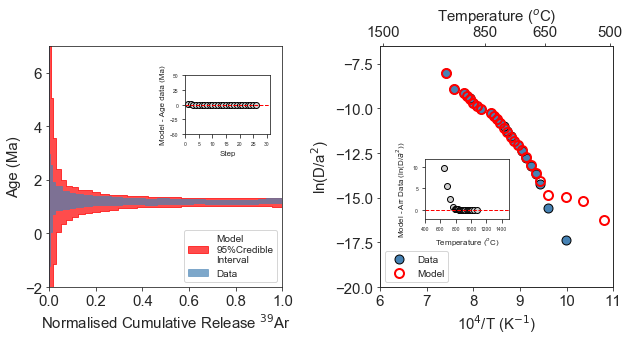

In [77]:
sns.set_style('ticks')

font= {"family": "Arial", 
      "weight": "normal",
      "size":15}

plt.rc("font", **font)




fig, ax = plt.subplots(1,2, figsize = (9, 5))

ax[0].fill_between(frel_model_plot, low2_plot, 
                 high2_plot, 
                color = 'r', 
                label = 'Model\n95%Credible\nInterval', 
                  step = 'pre', 
                  interpolate = True,  
                  lw = 1,
                  alpha = 0.7)


ax[0].fill_between(x_plot, 
                  age - age_err, 
                  age + age_err, 
                  color = 'steelblue', 
                  step = 'pre',
                  lw = 0.75,
                  label = 'Data',
                  alpha = 0.7)

ax[0].set_xlabel('Normalised Cumulative Release $^{39}$Ar')
ax[0].set_ylabel('Age (Ma)')




ax[1].plot(tplot[:N], np.log(da2[:N]), 
          'o', markerfacecolor = 'steelblue', 
          markeredgecolor = 'k', 
          markersize = 9, label = 'Data')


ax[1].plot(tplot[:len(Z1)],Z1, 'or',
             markerfacecolor = 'None',
            alpha = 1, 
             markeredgecolor = 'r', markeredgewidth = 2, 
            markersize = 9, 
            label = 'Model')



#### Temp #####

ax2 = ax[1].twiny()

Tdc = np.array([500,  650, 850,  1500])
Tp = 10e3/(Tdc + 273.15)
labels = list(['500', '650', '850',   
              '1500'])
ax2.plot(tplot[:N], np.log(da2[:N]), alpha = 0)
ax2.set_xlabel('Temperature ($^{o}$C)')
ax[1].set_xlim(Tp.min() - 0.1, Tp.max()+ 0.3)
ax2.set_xlim(Tp.min() -0.1, Tp.max()+ 0.1)

ax2.set_xlabel('Temperature ($^{o}$C)')
ax2.set_xticks(Tp)
ax2.set_xticklabels(labels)


ax3 =plt.axes([0.67,0.365,0.13,0.165])

ax3.plot(tempk[:len(Z1)] - 273.15, 
         Z1[:N] - np.log(da2[:len(Z1)]),
         'ok', 
        markeredgecolor = 'k', 
        markerfacecolor = 'lightgrey')
qqq = Z1 - np.log(da2[:len(Z1)])
ax3.axhline(0, lw = 1, ls = '--', 
           color = 'r')
ax3.set_ylabel('Model - Arr Data (ln(D/$a^{2}$))', fontsize = 8)
ax3.set_xlabel('Temperature ($^{o}$C)', fontsize = 8)
ax3.set_ylim(qqq.min() - 2, qqq.max() + 2)
ax3.tick_params(labelsize = 5)
ax3.locator_params(axis='x', nbins=6)
ax3.set_xlim(400, 1500)

ax[1].set_xlabel('10$^{4}$/T (K$^{-1}$)')
ax[1].set_ylabel('ln(D/a$^{2}$)')
ax[1].locator_params(axis='y', nbins=6)
ax[1].locator_params(axis='x', nbins=6)


ax4 =plt.axes([0.3,0.6,0.13,0.165])

ax4.plot(np.linspace(1, len(Z2), len(Z2)).astype(int), Z2 - age_data[:len(Z2)], 'ok', 
        markeredgecolor = 'k', 
        markerfacecolor = 'lightgrey')
qqq2 = Z2 - age[:N]
ax4.set_ylim(qqq2.min() - 50, qqq2.max() + 50)

ax4.axhline(0, lw = 1, ls = '--', 
           color = 'r')
ax4.set_ylabel('Model - Age data (Ma)', fontsize = 8)
ax4.set_xlabel('Step', fontsize = 8)
ax4.tick_params(labelsize = 5)
ax4.locator_params(axis='x', nbins=10)
ax4.set_xlim(0, N+5)
ax[0].set_ylim(-2, 7)
ax[0].set_xlim(0, 1)
ax[1].set_xlim(6, 11)
ax[0].legend(loc = 4, fontsize = 10)
ax[1].legend(loc = 3, fontsize = 10)
ax[1].set_ylim(-20, -6.5)

plt.tight_layout()
#plt.savefig('/Users/jackcarter/Desktop/aldercreek_model.pdf')

/Applications/anaconda3/lib/python3.6/site-packages/matplotlib/tight_layout.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


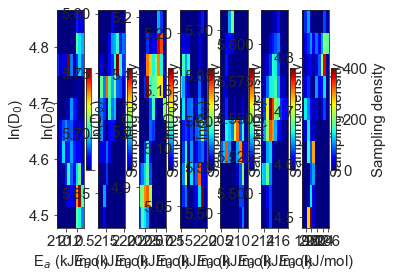

In [78]:
"""
Plot Natural log of D0 vs. EA
Looking for highly 
correlated sampling 
higher Ea
higher D0
"""


plt.figure(figsize = (5, 4))
for i in range(ncmp): 
    plt.subplot(1, ncmp, i+1)
    plt.hist2d(trace['ea'][:,i][-SAMPLES:],
                np.log(trace['d0'][:,i][-SAMPLES:]), 
               cmap = 'jet')


    plt.ylabel('ln(D$_{0}$)')
    plt.xlabel('E$_{a}$ (kJ/mol)')
    plt.ticklabel_format(useOffset=False)
    plt.colorbar(label = 'Sampling density')

    plt.tight_layout()
plt.locator_params(axis='x', nbins=6)

#plt.savefig('/Users/jackcarter/Desktop/alder_creek_diff')

In [79]:
low_d0, high_d0 = np.percentile(trace['d0'][-SAMPLES:][0], 
                            [16,84 ], 
                            axis = 0)
low_d0, high_d0

(119.65758182252347, 259.0788588409711)

In [80]:
logp_model = Q.logp
# Every Hundreth accepted sample
logp = [logp_model(i) for i in trace[-SAMPLES:]]
logp_x = np.array([logp])
logp_x = logp_x.reshape(SAMPLES)

/Applications/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


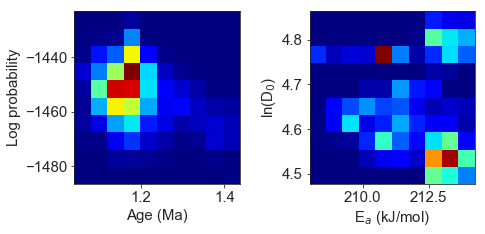

In [81]:
sns.set_style('ticks')

font= {"family": "Arial", 
      "weight": "normal",
      "size":15}

plt.rc("font", **font)

fig, ax = plt.subplots(1,2, figsize = (7,3.5))

z1 = ax[0].hist2d(trace['age_model'][-SAMPLES:][:,0],
                logp_x[-SAMPLES:].round(2), 
               cmap = 'jet')

z2 = ax[1].hist2d(trace['ea'][:,0][-SAMPLES:],
                np.log(trace['d0'][:,0][-SAMPLES:]), 
               cmap = 'jet')


ax[1].set_ylabel('ln(D$_{0}$)')
ax[1].set_xlabel('E$_{a}$ (kJ/mol)')
ax[1].ticklabel_format(useOffset=False)
#ax[1].set_xlim(220, 280)
#ax[1].set_ylim(6.3,6.63)
ax[0].set_ylabel('Log probability')
ax[0].set_xlabel('Age (Ma)')

plt.tight_layout()
#plt.savefig('/Users/jackcarter/Desktop/aldercreek_out.pdf')